## 0. Install dependencies

In [38]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
od.download("https://www.kaggle.com/c/airbus-ship-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tymofiij
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 28.6G/28.6G [57:42<00:00, 8.86MB/s]



Extracting archive .\airbus-ship-detection/airbus-ship-detection.zip to .\airbus-ship-detection


## 1. Observe the data
Things to remember when we work with image segmentation: <br>
Disable augmentation <br>
Avoid destructive resizing <br>
Always inspect the outputs visually

In [19]:
data_path = './airbus-ship-detection/' # directory of the data
train_csv ='./airbus-ship-detection/train_ship_segmentations_v2.csv'  # Path to the CSV train file 
test_dir = data_path+'test_v2/' # Directory where the test images are currently located
train_dir = data_path+'train_v2/' # Directory where the train images are currently located

Run-length encoding (https://www.youtube.com/watch?v=Yl50cJScObI)

In [5]:
df = pd.read_csv(train_csv)     
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### 1.1 Display image and segmentation

In [104]:
def decode_run_length(encoded_coordinates):
    pixel_numbers = []
    pixel_number = np.array(encoded_coordinates[::2])
    pixel_amount = np.array(encoded_coordinates[1::2])
    
    for i in range(len(pixel_amount)):
        for j in range(pixel_number[i], pixel_number[i] + pixel_amount[i]):
            pixel_numbers.append(j)

    pixel_numbers = np.array(pixel_numbers)
    
    return pixel_numbers

In [158]:
def plot_image(index):
    '''
    display the image
    param index: index of the dataset row
    '''
    # ImageId - column with path to the image in the training directory
    # EncodedPixels - column with run-length encoded pixels of the ship
    
    if (not pd.isna(df.loc[index, 'EncodedPixels'])):
        ship_encoded_pixels = list(df.loc[index, 'EncodedPixels'].split())
        ship_encoded_pixels = [int(x) for x in ship_encoded_pixels]
        image_path = train_dir + df.loc[index, 'ImageId']
        image = Image.open(image_path)
        pixel_numbers = decode_run_length(ship_encoded_pixels)
        
        x, y = np.unravel_index(pixel_numbers - 1, image.size[:2])
        
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(131)
        plt.imshow(image)
        plt.title('Original Image')
        plt.tick_params(axis='both', which='both', labelleft=False, labelbottom=False)

        # Segmented ship
        plt.subplot(132)
        plt.imshow(image)
        plt.scatter(x, y, color='red', marker='.')
        plt.title('Segmented ship')
        plt.tick_params(axis='both', which='both', labelleft=False, labelbottom=False)

        plt.tight_layout()
        plt.show()
    else:
        image_path = train_dir + df.loc[index, 'ImageId']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title('Image without Ship')
        plt.tick_params(axis='both', which='both', labelleft=False, labelbottom=False)
        plt.show()


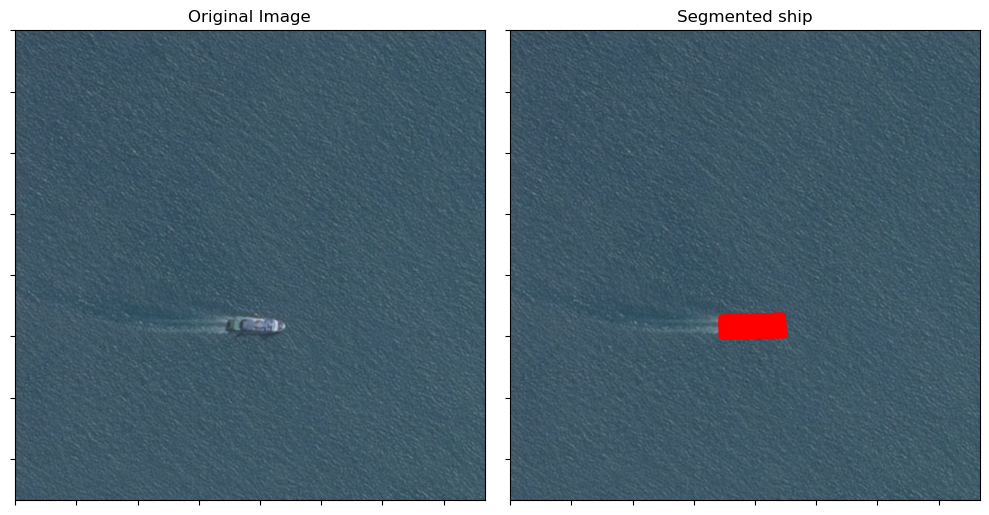

In [159]:
plot_image(2)

In [40]:
sizes = []
for image in os.listdir(train_dir):
    image = plt.imread(train_dir+image)
    sizes.append(image.shape)

In [42]:
widths = [shape[0] for shape in sizes]
heights = [shape[1] for shape in sizes]
dimensions = [shape[2] for shape in sizes]

width_counts = dict(zip(*np.unique(widths, return_counts=True)))
height_counts = dict(zip(*np.unique(heights, return_counts=True)))
dimension_counts = dict(zip(*np.unique(dimensions, return_counts=True)))

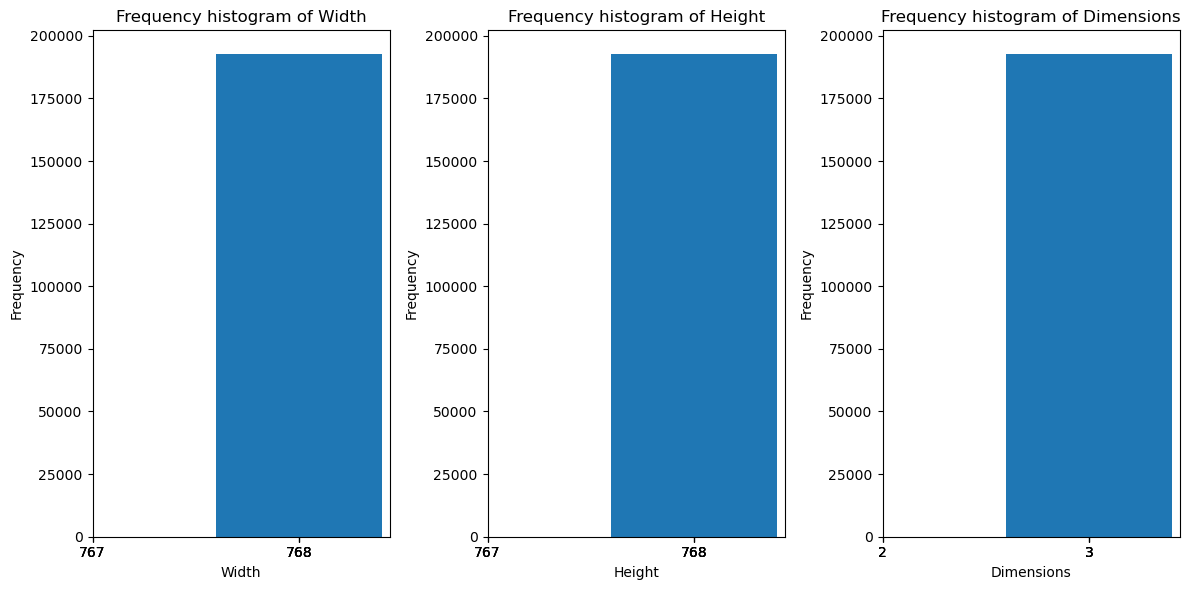

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.bar(width_counts.keys(), width_counts.values())
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Width')
plt.xticks(list(map(int, plt.xticks()[0])))  # Format x-axis labels as integers

plt.subplot(132)
plt.bar(height_counts.keys(), height_counts.values())
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Height')
plt.xticks(list(map(int, plt.xticks()[0])))  # Format x-axis labels as integers

plt.subplot(133)
plt.bar(dimension_counts.keys(), dimension_counts.values())
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Frequency histogram of Dimensions')
plt.xticks(list(map(int, plt.xticks()[0])))  # Format x-axis labels as integers

plt.tight_layout()

Count how many 0 ships images

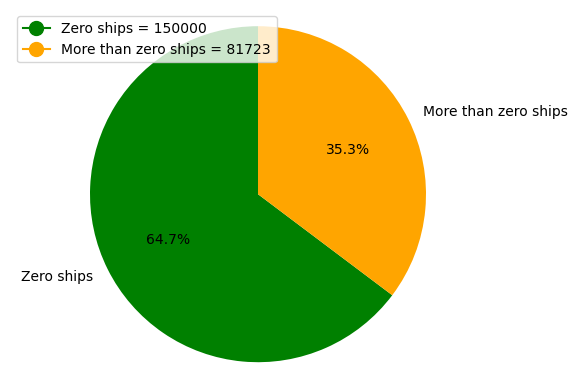

Zero ships image duplicates: 0
More than zero ship image duplicates: 0


In [147]:
zero_ships = df['EncodedPixels'].isna().sum()
non_zero_ships = df.shape[0] - zero_ships
total_rows = df.shape[0]
duplicates_with_nan = df[df.duplicated('ImageId') & df['EncodedPixels'].isna()].shape[0]
duplicates_with_ship = df[df.duplicated(['ImageId', 'EncodedPixels'])].shape[0]

labels = ['Zero ships', 'More than zero ships']
sizes = [zero_ships, non_zero_ships]

fig, ax = plt.subplots()

# Create a pie chart with custom legend labels
pie_wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'orange'])
ax.axis('equal') 

# Display custom legend labels with corresponding colors
legend_labels = [f'Zero ships = {zero_ships}', f'More than zero ships = {non_zero_ships}']
legend_handles = [plt.Line2D([0], [0], marker='o', color=color, label=label,
                            markerfacecolor=color, markersize=10) for color, label in zip([wedge.get_facecolor() for wedge in pie_wedges], legend_labels)]
plt.legend(handles=legend_handles, loc='upper left')

plt.show()

print(f'Zero ships image duplicates: {duplicates_with_nan}')
print(f'More than zero ship image duplicates: {duplicates_with_ship}')

Pictures with more than one ship:

In [52]:
num_unique_strings = df['ImageId'].nunique()
print(num_unique_strings)
duplicated_strings = df[df['ImageId'].duplicated()]['ImageId']
print(duplicated_strings)


192556
4         000194a2d.jpg
5         000194a2d.jpg
6         000194a2d.jpg
7         000194a2d.jpg
10        00021ddc3.jpg
              ...      
231656    ffea9a5ba.jpg
231657    ffea9a5ba.jpg
231670    ffef7c3f3.jpg
231671    ffef7c3f3.jpg
231713    fffd924fb.jpg
Name: ImageId, Length: 39167, dtype: object
